In [1]:
import numpy as np
from opentimspy import OpenTIMS
from pyproteolizard.data import PyTimsDataHandle



%load_ext autoreload
%autoreload 2

import collections
import pathlib
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 6)

import math
import numpy as np
import sklearn.cluster
import matplotlib.pyplot as plt
import matplotlib.colors
import opentimspy
from tqdm.notebook import tqdm
import itertools
import functools
import hdbscan
import sklearn.cluster
import time
import plotnine as p

from typing import (
    Callable,
    Iterable,
    Iterator,
    Tuple,
    Union,
    List,
)

from opentimspy.opentims import all_columns

import clusterMS.iterators
import clusterMS.stats
import clusterMS.scaling
import clusterMS.plotting
import clusterMS.math
import clusterMS.stitching


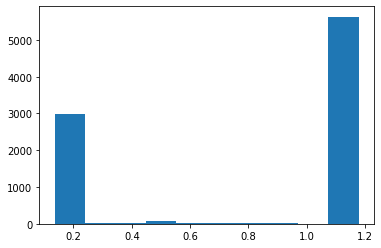

In [44]:
dh = PyTimsDataHandle(path)

plt.hist(np.diff(dh.meta_data[dh.meta_data.MsMsType == 0].Time))
plt.show()

In [45]:
# pd.DataFrame(rawdata.frames).query("MsMsType==0").iloc[:270]
path = "../../LSH/revision/data/M210115_001_Slot1-1_1_850.d/"
rawdata = opentimspy.OpenTIMS(path)

# filter out lower intensity then X
min_intensity = 25

# RT
tile_buffer_size_in_ms1_frames = 2 # the idea is to have these small
tile_bulk_size_in_ms1_frames = 266 # 

# MZ
tile_buffer_size_in_Daltons = 0.2
tile_bulk_size_in_Daltons = 2.0

# 
approximate_quantiles_cnt = 5000

# here we can also add m/z restrictions for debugging purposes
constraints_dict = {
    "multicharged": "inv_ion_mobility <= 0.5163458646616541 + 0.0007819548872180451 * mz",
    "above_min_intensity": f"intensity >= {min_intensity}"
}

# 
extracted_columns = opentimspy.opentims.all_columns
clustering_columns = ["scaled_width_preserving_mz", "scaled_scan", "scaled_ms1_frame"]
physical_columns = ["mz", "inv_ion_mobility", "retention_time"]
indices_columns = ["tof", "scan", "frame"]

# 
constraints=" and ".join(constraints_dict.values())
width_preserving_mz_scaling = math.log1p(1/72_900) / math.log1p(1/50_000)
scan_scale = 2**0.6
cycle_scale = 2**0.0
frame_scaling = 21 * 2**0.0


def rawdata_query(frames: np.array) -> pd.DataFrame:
    df = pd.DataFrame(rawdata.query(frames, columns=extracted_columns))
    df.query(constraints, inplace=True)# no complaint about setting a value on a slice
    df["width_preserving_mz"] = clusterMS.scaling.peak_width_preserving_mz_transform(df.mz)
    df["scaled_width_preserving_mz"] = df.width_preserving_mz / width_preserving_mz_scaling
    df["scaled_scan"] = df.scan / scan_scale
    df["scaled_ms1_frame"] = df.frame / frame_scaling
    return df


def get_clusters(data: pd.DataFrame) -> np.array:
    return hdbscan.HDBSCAN(
        algorithm="best",
        alpha=1.0,
        approx_min_span_tree=True,
        gen_min_span_tree=False,
        leaf_size=40,
        min_cluster_size=13,
        min_samples=1,
    ).fit_predict(data[clustering_columns])


ms1_tiles = clusterMS.iterators.iter_ms1_tiles(
    buffer_bulk_indices=clusterMS.iterators.get_buffer_bulk_indices(
        buffer_size_in_ms1_frames=tile_buffer_size_in_ms1_frames,
        bulk_size_in_ms1_frames=tile_bulk_size_in_ms1_frames,
        rawdata=rawdata,
    ),
    rawdata_query=rawdata_query,
)

get_mz_tiles_borders = functools.partial(
    clusterMS.stats.get_quasi_quantiles,
    buffer_size=tile_buffer_size_in_Daltons,
    bulk_size=tile_bulk_size_in_Daltons,
    approximate_quantiles_cnt=approximate_quantiles_cnt,
) # it might make sense to express all of these in terms of tofs?

get_mz_tile_areas_borders = clusterMS.stitching.get_simple_mz_tile_borders

get_ms1_tile_areas_borders = clusterMS.stitching.get_extension_ms1_tile_borders

get_mz_tile_status = functools.partial(
    clusterMS.stitching.decide_upon_cluster_identity,
    assignment_rules=clusterMS.stitching.simple_mz_tiles_assignment_rules,
)

get_ms1_tile_status = functools.partial(
    clusterMS.stitching.decide_upon_cluster_identity,
    assignment_rules=clusterMS.stitching.simple_ms1_tiles_assignment_rules,
)

# ms1_tile = next(ms1_tiles)
def get_cluster_stats(
    ms1_tiles: Iterable[clusterMS.tiles.MS1Tile],
    get_mz_tiles_borders: Callable[[np.array], np.array],
    get_clusters: Callable[[pd.DataFrame], np.array],
    get_mz_tile_areas_borders: Callable[[np.array,np.array], List[str]],
    get_ms1_tile_areas_borders: Callable[[np.array,np.array], List[str]],
    get_mz_tile_status: Callable[[np.array,np.array,np.array], List[str]],
    get_ms1_tile_status: Callable[[np.array,np.array,np.array], List[str]],
    dump_raw: bool=True,
    verbose: bool=False,
) -> pd.DataFrame:
    """Get cluster statistics.
    
    Problem: with the current version we have no guarantees that some boxes do not overlap.
    Therefore, the extracting as box we might extract a superset of the cluster.
    To avoid that, we would have to somehow index the points.
    But they are indexed by (frame, scan, tof): can that help?
    Yes, but that's like calling for the missing intensity too.
    Arguments:
        ms1_tiles (Iterable): A series of cycle tiles.
    Returns:
        pd.DataFrame: Cluster statistics.
    """
    all_stats = []
    for ms1_tile in ms1_tiles:
        mz_bin_borders = get_mz_tiles_borders(ms1_tile.data.mz.values)
        mz_tiles = clusterMS.iterators.split_into_mz_tiles(
            data=ms1_tile.data,
            mz_bin_borders=mz_bin_borders,
        )
        if verbose:
            mz_tiles = tqdm.tqdm(mz_tiles)
        mz_tile_clusters_stats = []
        # mz_tiles = itertools.islice(mz_tiles, 20)
        # mz_tile = next(mz_tiles)
        for mz_tile in mz_tiles:
            mz_tile.data["cluster"] = get_clusters(mz_tile.data)
            cluster_stats = clusterMS.stats.get_cluster_summary(mz_tile.data.query("cluster >= 0"))
            cluster_stats["mz_tile_status"] = get_mz_tile_status(
                starts=cluster_stats.start.mz,
                ends=cluster_stats.end.mz,
                tile_areas_borders=get_mz_tile_areas_borders(mz_tile),
            )
            mz_tile_clusters_stats.append(cluster_stats)
            # could dump raw data here??
            # no, because we would be dumping data that can extend into another MS1Tile.
        mz_tile_clusters_stats = pd.concat(mz_tile_clusters_stats)
        mz_tile_clusters_stats["ms1_tile_status"] = get_ms1_tile_status(
            starts=mz_tile_clusters_stats.start.frame,
            ends=mz_tile_clusters_stats.end.frame,
            tile_areas_borders=get_ms1_tile_areas_borders(ms1_tile),
        )
        # should dump some data here already: what to do with all the others?

        all_stats.append(mz_tile_clusters_stats)
    all_stats = pd.concat(all_stats, axis=0)
    
    return all_stats

In [46]:
ms1_tiles = clusterMS.iterators.iter_ms1_tiles(
    buffer_bulk_indices=clusterMS.iterators.get_buffer_bulk_indices(
        buffer_size_in_ms1_frames=tile_buffer_size_in_ms1_frames,
        bulk_size_in_ms1_frames=tile_bulk_size_in_ms1_frames,
        rawdata=rawdata,
    ),
    rawdata_query=rawdata_query,
)

In [47]:
for ms1_tile in tqdm(ms1_tiles):
    mz_bin_borders = get_mz_tiles_borders(ms1_tile.data.mz.values)
    mz_tiles = clusterMS.iterators.split_into_mz_tiles(data=ms1_tile.data, 
                                                       mz_bin_borders=mz_bin_borders)
        
    for mz_tile in mz_tiles:
        
        if np.max(mz_tile.data.intensity) > 1000:
            t = mz_tile
            break
    break

0it [00:00, ?it/s]

In [49]:
import abc
from pyproteolizardvis.point import ImsPointCloudVisualizer

class MyCustomPointVis(ImsPointCloudVisualizer, abc.ABC):
    def __init__(self, data, mztick=0.5):
        super().__init__(data)
        self.mztick = mztick
        
    def display_widgets(self):
        try:
            display(self.box)
        except Exception as e:
            print(e)
    def on_update_clicked(self, change):
        points = self.data#[0]
        #centroids = self.data[1]
        self.points_widget.data[0].x = points[:, 0]
        self.points_widget.data[0].y = points[:, 1]
        self.points_widget.data[0].z = points[:, 2]
        self.points_widget.data[0].marker = dict(size=self.point_size_slider.value,
        color=np.sqrt(points[:, 3]),
        colorscale=self.color_scale.value,
        line=dict(width=0),
        opacity=self.opacity_slider.value)
        # TODO: calculate spacing MZ as a function of filter range
        self.points_widget.update_layout(margin=dict(l=0, r=0, b=0, t=0),
        scene={'xaxis': {'title': 'Rt-Index'},
        'yaxis': {'title': 'Mobility-Index'},
        'zaxis': {'title': 'm/z', 'dtick': self.mztick}},
        template="plotly_white")
        
        
vis = MyCustomPointVis(t.data[['retention_time', 'inv_ion_mobility', 'mz', 'intensity']].values)

In [50]:
np.max(t.data[['retention_time', 'mz', 'scan', 'intensity']].intensity)

1743

In [51]:
vis.display_widgets()

In [ ]:
mz_tile_clusters_stats.groupby(["mz_tile_status","ms1_tile_status"]).size()

all_stats.groupby(["mz_tile_status","ms1_tile_status"]).size()
kept_clusters = all_stats[
    all_clusters_stats.decision=="keep"
]
clusterMS.plotting.plot_cluster_summary(
    df=kept_clusters["spread"].query("mz < .5 and retention_time < 300")[physical_columns]
)
clusterMS.plotting.plot_cluster_summary(
    df=kept_clusters["spread"].query("mz < .5 and retention_time < 300")[clustering_columns]
)

In [ ]:
all_stats = []

mz_bin_borders = get_mz_tiles_borders(cycle_tile.data.mz.values)
mz_tiles = clusterMS.iterators.split_into_mz_tiles(
    data=cycle_tile.data,
    mz_bin_borders=mz_bin_borders,
)

mz_tile_clusters_stats = []

mz_tiles = itertools.islice(mz_tiles, 20)
# mz_tile = next(mz_tiles)

for mz_tile in mz_tiles:
    mz_tile.data["cluster"] = get_clusters(mz_tile.data)
    cluster_stats = clusterMS.stats.get_cluster_summary(mz_tile.data.query("cluster >= 0"))
    cluster_stats["mz_tile_status"] = get_mz_tile_status(
        starts=cluster_stats.start.mz,
        ends=cluster_stats.end.mz,
        tile_areas_borders=get_mz_tile_areas_borders(mz_tile),
    )
    mz_tile_clusters_stats.append(cluster_stats)
    # could dump raw data here??
    # no, because we would be dumping data that can extend into another CycleTile.
mz_tile_clusters_stats = pd.concat(mz_tile_clusters_stats)
mz_tile_clusters_stats["cycle_tile_status"] = get_cycle_tile_status(
    starts=mz_tile_clusters_stats.start.frame,
    ends=mz_tile_clusters_stats.end.frame,
    tile_areas_borders=get_cycle_tile_areas_borders(cycle_tile),
)
# should dump some data here already: what to do with all the others?

all_stats.append(mz_tile_clusters_stats)
all_stats = pd.concat(all_stats, axis=0)

In [ ]:
"""
mz_tile_clusters_stats.groupby(["mz_tile_status","cycle_tile_status"]).size()

all_stats.groupby(["mz_tile_status","cycle_tile_status"]).size()
kept_clusters = all_stats[
    all_clusters_stats.decision=="keep"
]
clusterMS.plotting.plot_cluster_summary(
    df=kept_clusters["spread"].query("mz < .5 and retention_time < 300")[physical_columns]
)
clusterMS.plotting.plot_cluster_summary(
    df=kept_clusters["spread"].query("mz < .5 and retention_time < 300")[clustering_columns]
)
"""